In [65]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
import numpy.linalg as LA
from numpy.linalg import inv
import gzip
from tqdm import tqdm

In [2]:
import sys
import os
sys.path.append('..')

In [3]:
from utils.base import BaseProtein

In [4]:
protein = BaseProtein(file='../../Data/GxpS_ATC.pdb')

In [5]:
T = [i for i in range(538,608)] ## 539-608
protein.get_residues(T)

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [6]:
from Bio import AlignIO

In [7]:
class AlignTools():
    def __init__(self, path: str) -> None:
        self.align = AlignIO.read(path, "stockholm")
    
    def show_alignment(self):
        print(self.align)

    def get_alignment_length(self):
        return self.align.get_alignment_length()
    
    def get_num_sequences(self):
        return len(self.align)

    def get_pairwise_identity(self):
        pairwise_seqid = np.eye(self.get_num_sequences())

        for i, record_1 in enumerate(self.align):
            for j, record_2 in enumerate(self.align):
                seq_id = 0
                for s1, s2 in zip(record_1.seq, record_2.seq):
                    if s1 != '-' and s2 != '-' and s1 != '.' and s2 != '.' and s1 == s2:
                        seq_id += 1

                pairwise_seqid[i,j] = seq_id/self.get_alignment_length()

        return pairwise_seqid

In [8]:
align_obj = AlignTools('/data/users/kgeorge/workspace/ArDCA/msa.stockholm')

In [9]:
seqs = []
for res in align_obj.align:
    seqs.append(str(res.seq))

In [10]:
def letter2number(a): 
    #to convert the amino acids letters into integer numbers from 0 to 20
    switcher = {
        '-': 20,
        'A': 0,
        'C': 1,
        'D':2,
        'E':3,
        'F':4,
        'G':5,
        'H':6,
        'I':7,
        'K':8,
        'L':9,
        'M':10,
        'N':11,
        'P':12,
        'Q':13,
        'R':14,
        'S':15,
        'T':16,
        'V':17,
        'W':18,
        'Y':19,     
    }
    return switcher.get(a,0)

def dH(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

In [11]:
# # Open the file and write in "seqs" a list containing all lines
# data=gzip.open('/data/users/kgeorge/workspace/ArDCA/PF00014_mgap6.fasta.gz', 'r')
# seqs = data.readlines()[1::2]
# data.close()

In [12]:
seqs

['------------gdieis--LAEMWTDLLKI-DQ---V-GRHDNFFTLGGHSLLAVQMIEQLRRI--GLSLSVRALFDTPVLSVLAA--sl----------',
 '--------------geteDAIAAIWSELLGV-NQ---I-SRHDSFFALGGHSLLVVKMLDRLHR-L-GLTVSVRVLFESPTLSVLAQ--dl----------',
 '-------------gevem-KLAAIWSELLKV-DK---I-GRQDNFFMLGGHSLLAVQMIGQLRRI--GFVMSVRALFETPVLSVLAA--sit---------',
 '------------gdveig--LAEIWAELLSL-D--R-V-GRHDNFFMLGGHSLLAVRMAGSVRSRL-GLDLKLHSLFAAPTVAELAQ--klv---------',
 '-------------griec-ALAEIWAEVLKV-P--R-V-GRHDNFFLLGGHSLLAVRLMNRIST-L-GAQLPLSALFASPTLSSFAQA-f-----------',
 '-------------gevek-ALATIWTQLLKM-E--R-V-GRNDNFFMLGGHSLLAVQMIEQLRRI--GLSLSVRALFDTPVLSVLAA--sl----------',
 '--------------geteEAIAAIWSELLGV-NQ---I-SRHDSFFALGGHSLLVVKMLDRLHR-L-GLTVSVRVLFESPTLSVLAQ--dl----------',
 '-------------geiet-TLAATWSELLKI-DK---I-GRQDNFFMLGGHSLLAVQMIEQLRRM--GLVMSVRALFETPVLNVLAT--sic---------',
 '------------gdveig--LAEIWAELLSL-D--R-V-GRHDNFFMLGGHSLLAVRMSGSVRSRL-GLDLKLHTLFAAPTITDLAQ--kll---------',
 '-------------gviet-TVAAIWSEVLKI-DK---V-GRYDN

In [13]:
len(seqs) # This is the MSA

197

In [14]:
# ##DCA Example
# ##Extract L and M and convert the MSA in a numerical matrix
# M=np.size(seqs)
# L=len(seqs[0])-1
# Np=int(L*(L-1)/2)
# print(M,L)
# align=np.zeros((M,L)).astype(int)
# for m in range (M):
#     for i in range (L):
#         align[m,i]=letter2number(seqs[m].decode('utf-8')[i])

In [15]:
##Extract L and M and convert the MSA in a numerical matrix
M=np.size(seqs)
L=len(seqs[0])
Np=int(L*(L-1)/2)
print(M,L)
align=np.zeros((M,L)).astype(int)
for m in range (M):
    for i in range (L):
        align[m,i]=letter2number(seqs[m][i])

197 101


In [16]:
align

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       ...,
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20]])

In [17]:
align[0]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  0,  0,  0,  0,  0,
        0, 20, 20,  9,  0,  3, 10, 18, 16,  2,  9,  9,  8,  7, 20,  2, 13,
       20, 20, 20, 17, 20,  5, 14,  6,  2, 11,  4,  4, 16,  9,  5,  5,  6,
       15,  9,  9,  0, 17, 13, 10,  7,  3, 13,  9, 14, 14,  7, 20, 20,  5,
        9, 15,  9, 15, 17, 14,  0,  9,  4,  2, 16, 12, 17,  9, 15, 17,  9,
        0,  0, 20, 20,  0,  0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [18]:
align.shape

(197, 101)

In [19]:
## new sequences
align_new = np.zeros((len(align[:,1])+21,len(align[1,:])))
align_new[:-21,:] = align
for i in range(21):
    align_new[-i-1,:] = np.ones(L)*i
align_new

for i in range(L):
    np.random.shuffle(align_new[len(align[:,1]):,i])
align_new = align_new.astype(int)

In [20]:
len(align[:,1])

197

In [21]:
align_new[len(align[:,1]):,:]

array([[12,  2, 18, ...,  7, 17, 13],
       [ 9,  9, 13, ..., 20,  7, 17],
       [15, 18,  3, ...,  0, 13, 20],
       ...,
       [18, 16,  7, ...,  3, 11,  4],
       [ 5, 19, 19, ...,  2,  5,  0],
       [ 6, 13, 20, ..., 14,  9,  7]])

In [22]:
align_new

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       ...,
       [18, 16,  7, ...,  3, 11,  4],
       [ 5, 19, 19, ...,  2,  5,  0],
       [ 6, 13, 20, ..., 14,  9,  7]])

In [23]:
(align_new[:len(align[:,1]), :] == align).all()

True

In [24]:
align_new.shape

(218, 101)

In [25]:
## possibility to give a file with weights
# data=gzip.open('/data/users/kgeorge/workspace/ArDCA/weights_14.gz', 'r')
# trainingWeights = [float(i) for i in data.readlines()]
# data.close()
# #trainingWeights = np.loadtxt("weights_14") 
# trainingWeights_new = np.ones(len(trainingWeights)+21)*10**(-6)
# trainingWeights_new[:len(trainingWeights)] = trainingWeights

# uncomment these ligns to put uniform weights 
trainingWeights = np.ones(M) 
trainingWeights_new = np.ones(len(trainingWeights)+21)*10**(-6)

In [26]:
trainingWeights_new[:10]

array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06])

In [27]:
trainingWeights_new.shape, trainingWeights_new[-30:]

((218,),
 array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
        1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
        1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
        1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06]))

In [28]:
#Expand the alignment in a bynary (M,21xL) array (one-hot encoding)
q=21        
msa=np.zeros((M+21,L*q))#.astype(int)  
for m in range(M+21):
    for i in range(L):
        msa[m,i*q+align_new[m,i]]=1 

#Calculate the 1-point frequencies 
msa_reweighted = np.copy(msa[:M,:])

for i in range(len(msa[:M,1])):
    msa_reweighted[i,:] *= trainingWeights[i]/np.sum(trainingWeights)
p=np.sum(msa_reweighted,0)

In [29]:
(trainingWeights[0]/np.sum(trainingWeights)), (trainingWeights[0]/np.sum(trainingWeights))*M

(0.005076142131979695, 0.9999999999999999)

In [30]:
msa.shape, msa_reweighted.shape

((218, 2121), (197, 2121))

In [31]:
p[:21]

array([0.00507614, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.99492386])

In [32]:
p.shape

(2121,)

In [33]:
p.sum(), L

(101.00000000000009, 101)

In [34]:
msa

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
msa.shape

(218, 2121)

In [36]:
#Pseudocount alfa
alfa=0.0001
pa=(1-alfa)*p+alfa/21.

In [37]:
pa

array([5.08039642e-03, 4.76190476e-06, 4.76190476e-06, ...,
       4.76190476e-06, 4.76190476e-06, 9.94829127e-01])

In [38]:
pa.sum()

101.00000000000009

In [39]:
pa[:21], pa[:21].sum()

(array([5.08039642e-03, 4.76190476e-06, 4.76190476e-06, 4.76190476e-06,
        4.76190476e-06, 4.76190476e-06, 4.76190476e-06, 4.76190476e-06,
        4.76190476e-06, 4.76190476e-06, 4.76190476e-06, 4.76190476e-06,
        4.76190476e-06, 4.76190476e-06, 4.76190476e-06, 4.76190476e-06,
        4.76190476e-06, 4.76190476e-06, 4.76190476e-06, 4.76190476e-06,
        9.94829127e-01]),
 1.000000000000002)

#### Routine with sklearn

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
lreg = LogisticRegression(penalty='l2', tol=0.001, C=0.01, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=5000, multi_class='multinomial', verbose=0)

In [42]:
#test
i = 1
regsite1 = lreg.fit(msa[0:,:i*q], align_new[0:,i], sample_weight=trainingWeights_new)

In [43]:
msa[0:,:i*q].shape, align_new[0:,i].shape

((218, 21), (218,))

In [44]:
print(regsite1.score(msa[0:,:i*q], align_new[0:,i]))

0.9036697247706422


#### Sampling and learning

In [45]:
def one_hot_enc(sample,M):
    #M = len(sample[:,1])
    L = len(sample[1,:])
    one_h=np.zeros((M,L*q))#.astype(int)  
    for m in range(M):
        for i in range(L):
            one_h[m,i*q+int(sample[m,i])-1]=1 
    return one_h

In [46]:
M, L, q

(197, 101, 21)

In [47]:
# J = np.zeros((L,q**2*(L-1)+q))
# nb_sample = 20
# sample = np.zeros((nb_sample,L))
# site = 0
# J[0, q**2*(L-1):] = np.log(pa[:q])

# for i in range(nb_sample):
#     sample[i, site] =  np.random.choice(np.arange(1,22), 1, p=pa[:q])[0]

In [48]:
# sample[:,0]

array([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
       21., 21., 21., 21., 21., 21., 21.])

In [54]:
# for i in range(1,L):
#     reg = lreg.fit(msa[0:,:i*q], align_new[0:,i], sample_weight=trainingWeights_new)
#     Jtemp = reg.coef_
    
#     for j in range(i):
#         for k in range(q):
#             J[i,j*q**2+k*q:(k+1)*q+j*q**2] = Jtemp[k,j*q:(j+1)*q]
    
#     classes = reg.classes_
#     prob = reg.predict_proba(one_hot_enc(sample[:,:i],nb_sample))
#     J[i,q**2*(L-1):]  = reg.intercept_
#     for j in range(nb_sample):
#         sample[j,i] =  np.random.choice(classes+1, 1, p=prob[j,:])[0]

#     break
# sample-=1

In [66]:
J = np.zeros((L,q**2*(L-1)+q))
nb_sample = 100
sample = np.zeros((nb_sample,L))
site = 0
J[0, q**2*(L-1):] = np.log(pa[:q])

for i in range(nb_sample):
    sample[i, site] =  np.random.choice(np.arange(1,22), 1, p=pa[:q])[0]

for i in tqdm(range(1,L)):
    reg = lreg.fit(msa[0:,:i*q], align_new[0:,i], sample_weight=trainingWeights_new)
    Jtemp = reg.coef_

    for j in range(i):
        for k in range(q):
            J[i,j*q**2+k*q:(k+1)*q+j*q**2] = Jtemp[k,j*q:(j+1)*q]
    classes = reg.classes_
    
    prob = reg.predict_proba(one_hot_enc(sample[:,:i],nb_sample))
    
    J[i,q**2*(L-1):]  = reg.intercept_
    for j in range(nb_sample):
        sample[j,i] =  np.random.choice(classes+1, 1, p=prob[j,:])[0]
    
sample-=1

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


In [67]:
sample.shape, J.shape, pa.shape, msa.shape, align_new.shape

((100, 101), (101, 44121), (2121,), (218, 2121), (218, 101))

In [68]:
sample

array([[20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.],
       [20.,  8., 20., ...,  7., 20., 20.],
       ...,
       [20., 20., 20., ..., 20., 20., 20.],
       [20., 16., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.]])

In [69]:
sample_one_hot =np.zeros((nb_sample,L*q))#.astype(int)  
for m in range(nb_sample):
    for i in range(L):
        sample_one_hot[m,i*q+int(sample[m,i])]=1 

In [70]:
sample_one_hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [71]:
freq_data = np.zeros(q*L)
freq_sample = np.zeros(q*L)
for i in range(q*L):
    freq_data[i] = np.sum(msa_reweighted[:,i])
    freq_sample[i] = np.sum(sample_one_hot[:,i])/nb_sample

In [72]:
p.shape, freq_sample.shape

((2121,), (2121,))

Text(0, 0.5, 'Sample arDCA')

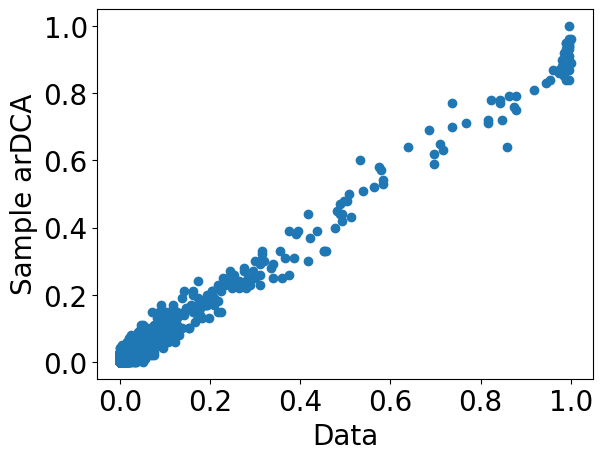

In [73]:
plt.scatter(p,freq_sample)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Data",size = 20)
plt.ylabel("Sample arDCA",size = 20)

In [74]:
sample

array([[20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.],
       [20.,  8., 20., ...,  7., 20., 20.],
       ...,
       [20., 20., 20., ..., 20., 20., 20.],
       [20., 16., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.]])

In [82]:
def number2letter(a): 
    #to convert the amino acids letters into integer numbers from 0 to 20
    switcher = {
        '-': 20,
        'A': 0,
        'C': 1,
        'D':2,
        'E':3,
        'F':4,
        'G':5,
        'H':6,
        'I':7,
        'K':8,
        'L':9,
        'M':10,
        'N':11,
        'P':12,
        'Q':13,
        'R':14,
        'S':15,
        'T':16,
        'V':17,
        'W':18,
        'Y':19,     
    }
    reverse = {v:k for k,v in switcher.items()}
    
    return reverse.get(a,0)

In [83]:
sample.shape

(100, 101)

In [88]:
generated_sequences = []
generated_sequences_aligned = []
for m in range (sample.shape[0]):
    temp = []
    for i in range (sample.shape[1]):
        temp.append(number2letter(sample[m][i]))
    seq = ''.join(temp)
    generated_sequences.append(seq.replace('-',''))
    generated_sequences_aligned.append(seq)

In [90]:
generated_sequences[:10]

['TMAAKLCPEDVLGPEEIGVNDDFFRLGGDSLLANAVSGLINTASNIHISERDIFQNSTLSQLAA',
 'DAAAAARALAQLWSSDLGNQQEGASDKFFKLGGDSLSARLIALAHQAKHTLPVAQVMQYPTVADLAAAG',
 'KFAAPLSTLWSQLDVSAQLGIHDNFFQVGGHSVFAIQGVNMLRRHSLSLTVGEIFENPTLFGLVAYI',
 'FAAANDNIWSKILGINSVDRRDNFFSAGGHSLSAMKLIARAKIMGVALKVGEIFENGTLQKLARMLA',
 'PCAAAAKLESLWAQLLQVGSLINIHDHRDAVGGDSLGADTVVAAVRKNGAGWSLKDIFENRTIKNLAAS',
 'AAAAWLTAISEDLSAPTLVTNDSFFQLGGDSLKAIQLAARARRMGFQISVSDLFDKPTLASLHYAA',
 'MAAAAWQGWSRVLNILPDVSTHDDFFDIGGHSLFILLVAVLRARQGIELSIKTVYQLPTINRAAAR',
 'LAAAAIKLHDFCRVFKPVNVDSFFALGGHSLDLTQIVHRTRRIGLLLSTQGVLDTPVLSALAEI',
 'AKYAAASVRIWRELGVRSTRIGIEDNFFALGGDPLLSMNRINRAHAYFNTTLPLKDHFETPTIQELAQ',
 'EAAAAISLAEFWAELRLEKCMAGRDDHFFEICGDELLAIQVVSGLSKHGWALAFADTFKHPTIAQLAAIAM']

In [91]:
generated_sequences_aligned[:10]

['---T-------M----AA-KLC-P-EDVLGP-E-E--I-GVNDDFFRLGGDSLLANAVSGLINTAS-NIHISERDIFQNSTLSQLA---A-----------',
 '----D--AA------AAARALAQLWSSDLGN-QQ-E---GASDKFFKLGGDSLSA-RLIALAHQA--KHTLPVAQVMQYPTVADLA----AA-G-------',
 '-K-------------FAAP-LSTLWSQ-LDV-S-AQ-L-GIHDNFFQVGGHSVFAIQGVNMLRRH--SLSLTVGEIFENPTLFGL---V-AY------I--',
 '----F--------A-AAN---DNIWSKILGI-N--S-V-DRRDNFFSAGGHSLSAMKLIARA-KIM-GVALKVGEIFENGTLQKLAR--MLA---------',
 '-------P----C-AAAA-KLESLWAQLLQV-G-SL-I-NIHDHRDAVGGDSLGADTVVAAVRKN--GAGWSLKDIFENRTIKNLA---A--------S--',
 '-------------A-AAAW-LTAISED-LSA-PTL--V--TNDSFFQLGGDSLKAIQLAARARR-M-GFQISVSDLFDKPTLASLH-Y-A----A------',
 '----M---------AAAA--WQG-WSRVLNI-LPD--V-STHDDFFDIGGHSLF-ILLVAVLRARQ-GIELSIKTVYQLPTIN-RA---A---A--R----',
 '-----L--------AAAAIKLHD-FCRVFK---P---VN-V-DSFFALGGHSLDLTQIVHRTRRI--GLLLSTQGVLDTPVLSALAE------------I-',
 '-------A-K----YAAA-S-VRIWRE-LGV-RSTR-I-GIEDNFFALGGDPLLSMNRINRAHAYF-NTTLPLKDHFETPTIQELAQ--------------',
 '-------------EAAAAISLAEFWAE-LRL-EK--CMAGRDDH

In [92]:
T = [i for i in range(538,608)] ## 539-608
protein.get_residues(T)

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [96]:
fasta_file = '/nethome/kgeorge/workspace/DomainPrediction/Data/DCA_experiments/gen_seq.fasta'
with open(fasta_file, 'w') as fout:
    fout.write('>GxpS_T\n')
    fout.write(protein.get_residues(T) + '\n')
    for i, seq in enumerate(generated_sequences):
        fout.write(f'>GxpS_T-gen_{i}\n')
        fout.write(seq + '\n')